In [7]:
import pandas as pd
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from db import connect
%matplotlib inline

In [62]:
PS = nltk.stem.PorterStemmer()
DB = connect()
credits = pd.DataFrame(list(DB.credits.find({})))
movies = pd.DataFrame(list(DB.movies.find({})))
df_initial = convert_to_original_format(movies, credits)
df_initial.head()

,_id,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,...,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,5ecff7be2939cf463b2d327e,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
1,5ecff7be2939cf463b2d3286,250000000,Action|Adventure|Fantasy,http://www.batmanvsupermandawnofjustice.com/,209112,dc comics|vigilante|superhero|based on comic b...,English,Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super Hero l...,155.790452,...,Justice or revenge,Batman v Superman: Dawn of Justice,5.7,7004,2016,United States of America,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
2,5ecff7be2939cf463b2d3288,200000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,58,witch|fortune teller|bondage|exotic island|mon...,English,Pirates of the Caribbean: Dead Man's Chest,Captain Jack Sparrow works his way out of a bl...,145.847379,...,Jack is back!,Pirates of the Caribbean: Dead Man's Chest,7.0,5246,2006,Jamaica,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
3,5ecff7be2939cf463b2d3289,255000000,Action|Adventure|Western,http://disney.go.com/the-lone-ranger/,57201,texas|horse|survivor|texas ranger|partner|outl...,English,The Lone Ranger,The Texas Rangers chase down a gang of outlaws...,49.046956,...,Never Take Off the Mask,The Lone Ranger,5.9,2311,2013,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
4,5ecff7be2939cf463b2d328a,225000000,Action|Adventure|Fantasy|Science Fiction,http://www.manofsteel.com/,49521,saving the world|dc comics|superhero|based on ...,English,Man of Steel,A young boy learns that he has extraordinary p...,99.398009,...,You will believe that a man can fly.,Man of Steel,6.5,6359,2013,United Kingdom,Bryan Singer,Kevin Spacey,Kate Bosworth,James Marsden


In [ ]:
Визначення найпопулярніших ключових слів для опису фільму

In [63]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')


In [13]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # сортування за поширеністю
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [64]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['duringcreditsstinger', 178],
 ['based on novel', 91],
 ['aftercreditsstinger', 90],
 ['dystopia', 74],
 ['woman director', 74]]

In [ ]:
Гістограма та "хмара" ключових слів за популярністю

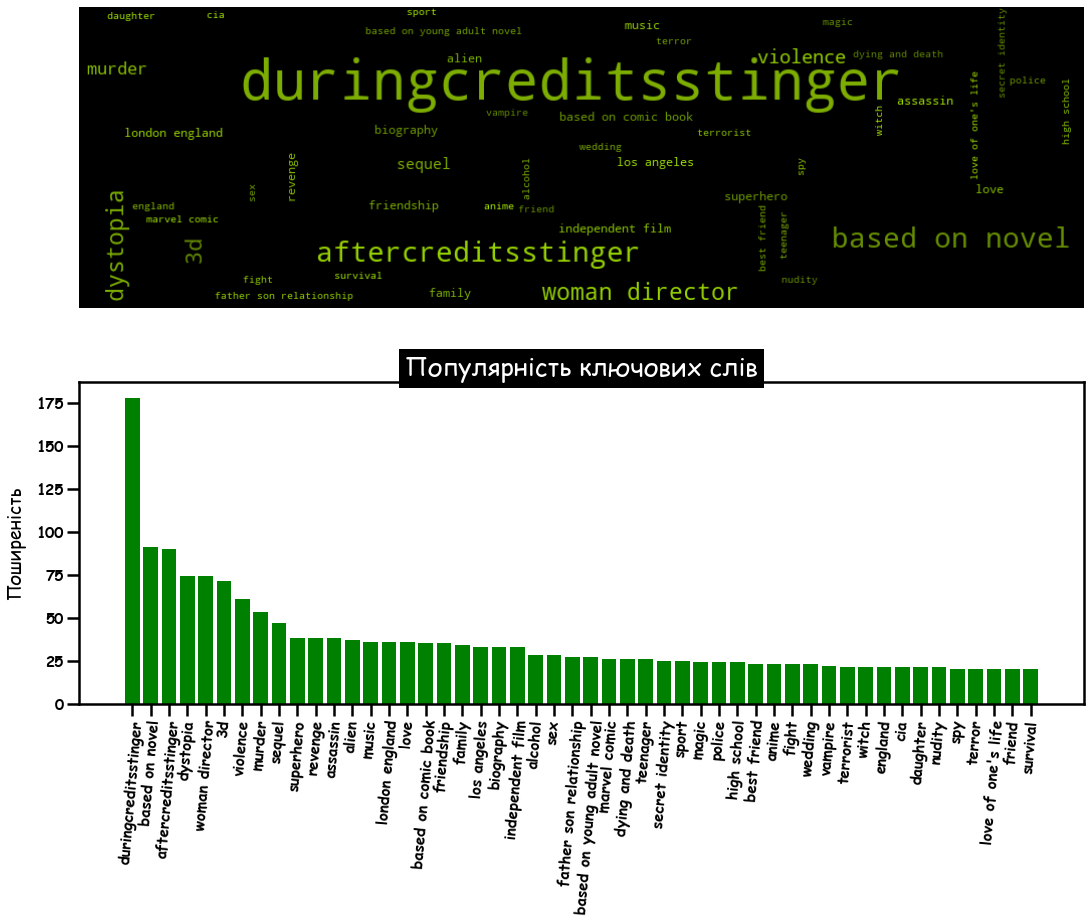

In [99]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)


words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0

wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Поширеність", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')

plt.title("Популярність ключових слів",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [ ]:
Статистика "цілісності" даних

In [19]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,country,3,99.759808
1,actor_3_name,2,99.839872
2,actor_2_name,1,99.919936
3,language,1,99.919936
4,_id,0,100.000000
5,actor_1_name,0,100.000000
6,director_name,0,100.000000
7,title_year,0,100.000000
8,num_voted_users,0,100.000000
9,vote_average,0,100.000000


In [ ]:
Відсоток випущених фільмів за декаду

In [97]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

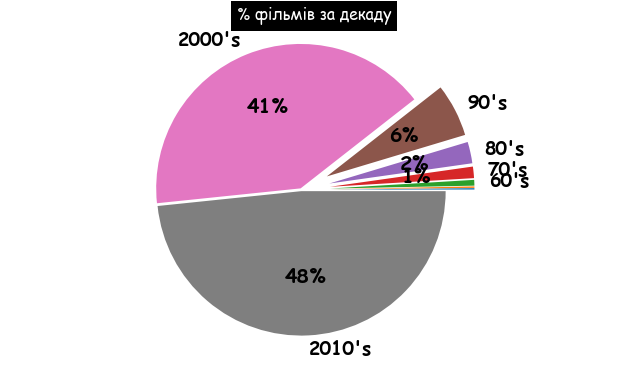

In [98]:
sns.set_context("poster", font_scale=0.85)

def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 60 else "{}'s".format(int(val))
    return chaine

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(8)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% фільмів за декаду',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)


In [ ]:
Визначаємо фільмів яких жанрів знято найбільше

In [46]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))


In [47]:
genres_occurences, dum = count_word(df_initial, 'genres', genre_labels)
genres_occurences[:5]


[['Drama', 501],
 ['Comedy', 410],
 ['Action', 394],
 ['Thriller', 356],
 ['Adventure', 304]]

In [ ]:
Графічне зображення популярності жанрів

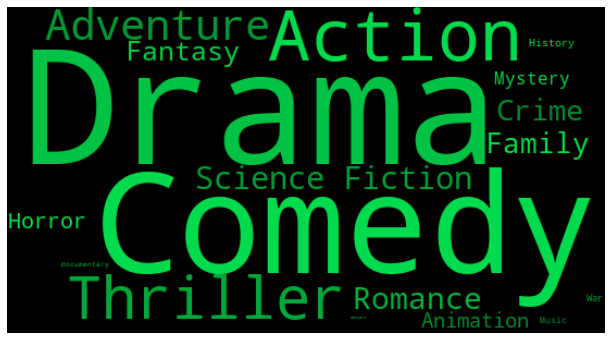

In [49]:
words = dict()
trunc_occurences = genres_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
Очищення данних: синоніми, повтори і тд

In [51]:
df_duplicate_cleaned = df_initial


In [66]:
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()
    keywords_select = dict()
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [67]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'plot_keywords')


Nb of keywords in variable 'plot_keywords': 5004


In [68]:
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'terrorism', 'terror'} 2
2 {'flooding', 'flood'} 2
3 {'friend', 'friends'} 2
4 {'human', 'humanity'} 2
5 {'supernatural powers', 'supernatural power'} 2
6 {'alienation', 'alien'} 2
7 {'animal', 'animation', 'anime'} 3
8 {'womanizer', 'woman'} 2
9 {'imprisonment', 'imprisoned'} 2
10 {'transformers', 'transformation'} 2
11 {'video game', 'video gamer'} 2
12 {'orc', 'orcs'} 2
13 {'destroy', 'destroyer'} 2
14 {'occult', 'occultism'} 2


In [73]:
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.at[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new

In [74]:
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)

In [75]:
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['duringcreditsstinger', 178],
 ['based on novel', 91],
 ['aftercreditsstinger', 90],
 ['dystopia', 74],
 ['woman director', 74]]

In [76]:
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma

In [80]:
# nltk.download('wordnet')
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

"stranger                      " in keywords list -> True 1
 "alien                         " in keywords list -> True 37
 "noncitizen                    " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0
 "unknown                       " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0


In [81]:
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [82]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
# заміна ключових слів на ті у яких більше поширеність
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue
    
    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue
    if mot == liste_mots[0][0]: continue
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

apparition   -> phantom      (init: [('phantom', 2), ('apparition', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
stage        -> stagecoach   (init: [('stagecoach', 1), ('stage', 1)])
engineering  -> technology   (init: [('technology', 5), ('engineering', 1)])
story        -> narration    (init: [('narration', 5), ('history', 4), ('tale', 1), ('story', 1)])
fighter      -> hero         (init: [('hero', 13), ('fighter', 1), ('champion', 1)])
origin       -> blood        (init: [('blood', 18), ('origin', 1), ('extraction', 1)])
__________________________________________________________________________________________
The replacement concerns 6.1% of the keywords.


In [83]:
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]   

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
failure              -> loser               
world                -> public              
baby                 -> sister              
stage                -> stagecoach          
origin               -> blood               
saloon               -> bar                 
fall                 -> twilight            
threat               -> terror              
world                -> public              


In [84]:
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 4699


In [85]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['duringcreditsstinger', 178],
 ['based on novel', 91],
 ['aftercreditsstinger', 90],
 ['dystopia', 74],
 ['woman director', 74]]

In [88]:
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.at[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new

In [89]:
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 769


In [90]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]


[['duringcreditsstinger', 178],
 ['based on novel', 91],
 ['aftercreditsstinger', 90],
 ['dystopia', 74],
 ['woman director', 74]]

In [91]:
Графік кількості появу ключових слів


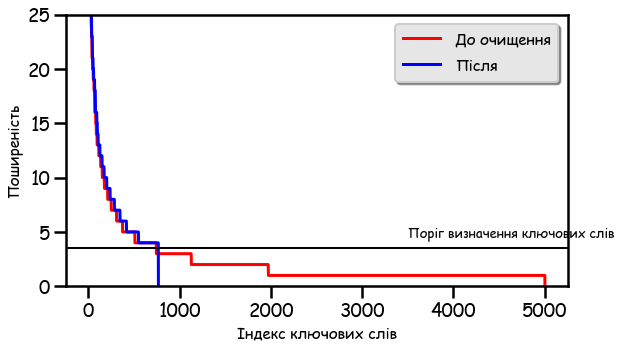

In [95]:
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='До очищення')
ax.plot(new_x_axis, new_y_axis, 'b-', label='Після')

legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("Індекс ключових слів", family='fantasy', fontsize = 15)
plt.ylabel("Поширеність", family='fantasy', fontsize = 15)
plt.text(3500, 4.5, 'Поріг визначення ключових слів', fontsize = 13)
plt.show()

In [ ]:
Кореляційні коефіцієнти 

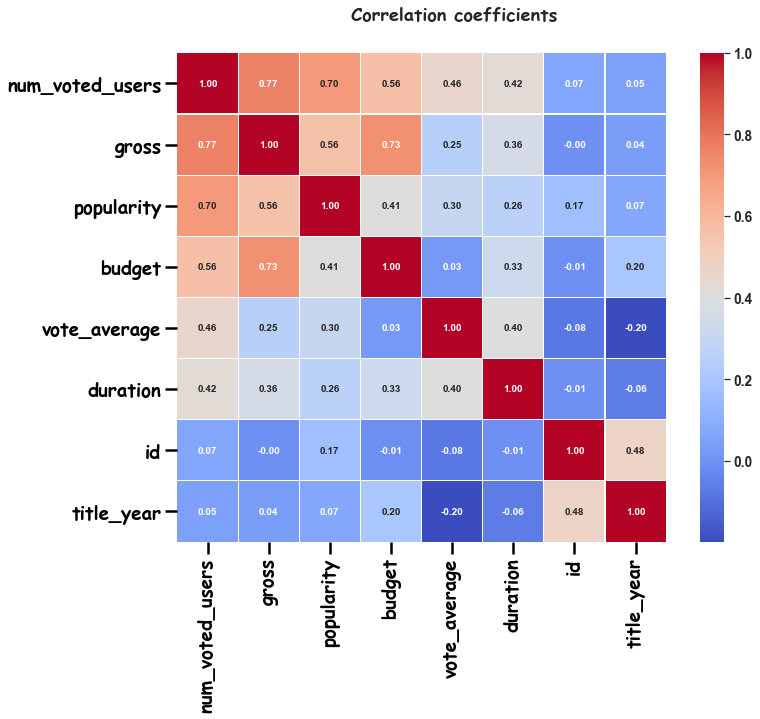

In [100]:
f, ax = plt.subplots(figsize=(12, 9))

corrmat = df_keywords_occurence.dropna(how='any').corr()

k = 17
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [ ]:
Цілісність данних

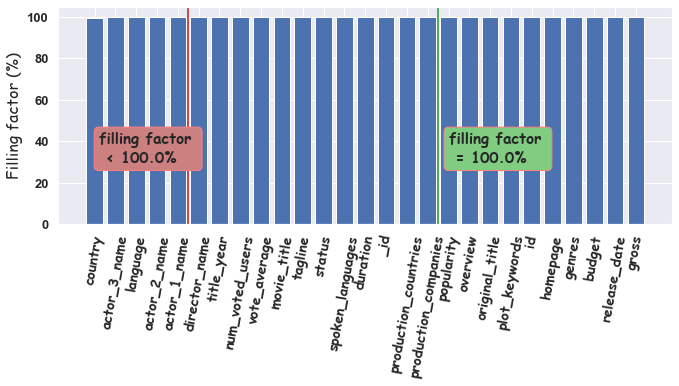

In [108]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)

y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'Фактор наповнення \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'Фактор наповнення \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

In [ ]:
Графіки касових зборів та користувачів, що залишили оцінку

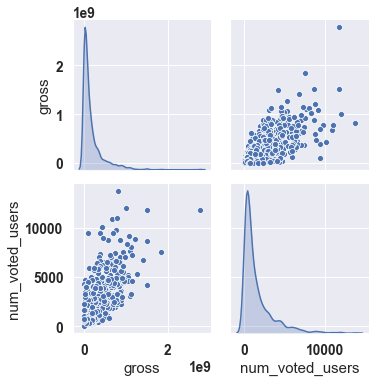

In [105]:
sns.set(font_scale=1.25)
cols = ['gross', 'num_voted_users']
sns.pairplot(df_keywords_occurence.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show()